In [1]:
import sys
import os
import pandas as pd

In [2]:
sys.path.append('..')

In [3]:
from icenode.train_icenode_2lr import ICENODE
from icenode.train_gram import GRAM
from icenode.train_retain import RETAIN

%load_ext autoreload
%autoreload 2

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


## Define Directories

In [4]:
HOME = os.environ.get('HOME')

# MIMIC-III Dataset Directory
mimic3_dir = f'{HOME}/GP/ehr-data/mimic3-transforms'

# ICE-NODE/M trained on MIMIC-III training partition (70%)
icenode_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.2.09.aM3_icenode_2lr_M/trial_572'

# RETAIN trained on MIMIC-III training partition (70%)
# retain_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_retain_M/frozen_trial_142'

# # GRU=GRAM/M trained on MIMIC-III training partition (70%)
# gru_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_M/frozen_trial_615'

# # GRAM=GRAM/G trained on MIMIC-III training partition (70%)
# gram_m3_dir = f'{HOME}/GP/ehr-data/icenode-m3-exp/v0.1.23M3_gram_G/frozen_trial_442'

## Patient Interface for each Model

In [5]:
icnode_patient_interface = ICENODE.create_patient_interface(mimic3_dir, 'M3')

## Dataset Partitioning

In [6]:
import random

# seed 42 is used in all our experiments in this work.
rng = random.Random(42)
subjects_id = list(icnode_patient_interface.subjects.keys())
rng.shuffle(subjects_id)

# splits = train:val:test = 0.7:.15:.15
splits = int(.7 * len(subjects_id)), int(.85 * len(subjects_id))

train_ids = subjects_id[:splits[0]]
valid_ids = subjects_id[splits[0]:splits[1]]
test_ids = subjects_id[splits[1]:]

## Load Configs and Trained Params

In [8]:
from icenode.utils import load_config, load_params

icenode_config = load_config(f'{icenode_m3_dir}/config.json')
icenode_params = load_params(f'{icenode_m3_dir}/step0100_params.pickle')

# retain_config = load_config(f'{retain_m3_dir}/config.json')
# retain_params = load_params(f'{retain_m3_dir}/step0100_params.pickle')

# gru_config = load_config(f'{gru_m3_dir}/config.json')
# gru_params = load_params(f'{gru_m3_dir}/step0100_params.pickle')

# gram_config = load_config(f'{gram_m3_dir}/config.json')
# gram_params = load_params(f'{gram_m3_dir}/step0100_params.pickle')

## Create Model Objects

In [9]:
icenode_config

{'emb': {'diag': {'embeddings_dim': 210}, 'kind': 'matrix'},
 'model': {'ode_dyn': 'mlp',
  'ode_init_var': 2.176580445753393e-06,
  'ode_with_bias': False,
  'state_size': 30,
  'timescale': 60},
 'training': {'batch_size': 12,
  'decay_rate1': 0.2778668914083504,
  'decay_rate2': 0.42398839640494357,
  'epochs': 20,
  'loss_mixing': {'L_dyn': 0, 'L_l1': 0, 'L_l2': 0},
  'lr1': 1.3977101963873734e-05,
  'lr2': 0.0013627713207478701,
  'optimizer': 'adam'}}

In [10]:
icenode = ICENODE.create_model(icenode_config, icnode_patient_interface, train_ids, None)
model_state = icenode.init_with_params(icenode_config, icenode_params)
# retain = RETAIN.create_model(retain_config, retain_patient_interface, train_ids, None)
# gru = GRAM.create_model(gru_config, gram_patient_interface, train_ids, None)
# gram = GRAM.create_model(gram_config, gram_patient_interface, train_ids, None)

In [11]:
code_partitions = ICENODE.code_partitions(icnode_patient_interface, train_ids) 

In [12]:
from icenode.metrics import evaluation_table
res = icenode.eval(model_state, test_ids)

In [13]:
eval_df = evaluation_table({'TST': res}, code_partitions)

/home/asem/.conda/envs/icenode/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:5338: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


In [14]:
eval_df

(                           TST
 Kfe               5.196200e+01
 MACRO-AUC         9.437334e-01
 MICRO-AUC         9.450204e-01
 accuracy          8.531252e-01
 admissions_count  1.009000e+03
 dyn_loss          9.724561e-09
 f1-score          1.644448e-01
 fn                2.009426e-03
 fp                1.448654e-01
 loss              7.764620e-02
 nfe_per_week      8.254095e-01
 npv               9.976098e-01
 odeint_weeks      6.295300e+04
 pre_ACC-P0        1.417607e-01
 pre_ACC-P1        3.485165e-01
 pre_ACC-P2        4.460074e-01
 pre_ACC-P3        7.466518e-01
 pre_ACC-P4        9.388795e-01
 precision         9.071852e-02
 prediction_loss   7.764620e-02
 recall            8.779397e-01
 specificity       8.527099e-01
 tn                8.386720e-01
 tp                1.445314e-02,
 {'TST_loss': 0.07764620333909988,
  'TST_prediction_loss': 0.07764620333909988,
  'TST_dyn_loss': 9.724560712243147e-09,
  'TST_admissions_count': 1009.0,
  'TST_odeint_weeks': 62953.0,
  'TST_nfe_p

## Analyse AUC for Each Admission in the Test Partition

In [15]:
icenode_auc_df = icenode.admissions_auc_scores(model_state, test_ids)

In [16]:
icenode_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,AUC,N_CODES,TIME,INTERVALS,LOS,NFE
0,19842,169734,0,0.958836,9.0,412.5,412.5,3.5,62.0
1,19842,186772,1,0.957278,16.0,433.5,21.0,7.5,26.0
2,19842,180229,2,0.973228,9.0,448.5,15.0,3.5,26.0
3,19842,122439,3,0.973928,13.0,509.5,61.0,7.5,32.0
4,19842,163738,4,0.992028,13.0,552.5,43.0,5.5,32.0
...,...,...,...,...,...,...,...,...,...
1004,26421,192868,1,0.963939,6.0,278.5,186.0,3.5,44.0
1005,2558,105758,0,0.887506,11.0,59.5,59.5,4.5,32.0
1006,2558,194247,1,0.983136,8.0,70.5,11.0,4.5,20.0
1007,10832,196835,0,0.965026,9.0,647.5,647.5,8.5,68.0


In [31]:
icenode_auc_df['NFE'] = icenode_auc_df['NFE'].astype(int)
icenode_auc_df['NFEpday'] = icenode_auc_df['NFE'].astype(int) / icenode_auc_df['INTERVALS']
icenode_auc_df['N_CODES'] = icenode_auc_df['N_CODES'].astype(int)


In [32]:
icenode_auc_df.dtypes

SUBJECT_ID      int64
HADM_ID         int64
HADM_IDX        int64
AUC           float64
N_CODES         int64
TIME          float64
INTERVALS     float64
LOS           float64
NFE             int64
NFE/day        object
NFEpday       float64
dtype: object

In [33]:
icenode_stat = icenode_auc_df[['AUC', 'N_CODES', 'INTERVALS', 'LOS', 'NFE', 'NFEpday']]

In [34]:
icenode_stat

,AUC,N_CODES,INTERVALS,LOS,NFE,NFEpday
0,0.958836,9,412.5,3.5,62,0.150303
1,0.957278,16,21.0,7.5,26,1.238095
2,0.973228,9,15.0,3.5,26,1.733333
3,0.973928,13,61.0,7.5,32,0.524590
4,0.992028,13,43.0,5.5,32,0.744186
...,...,...,...,...,...,...
1004,0.963939,6,186.0,3.5,44,0.236559
1005,0.887506,11,59.5,4.5,32,0.537815
1006,0.983136,8,11.0,4.5,20,1.818182
1007,0.965026,9,647.5,8.5,68,0.105019


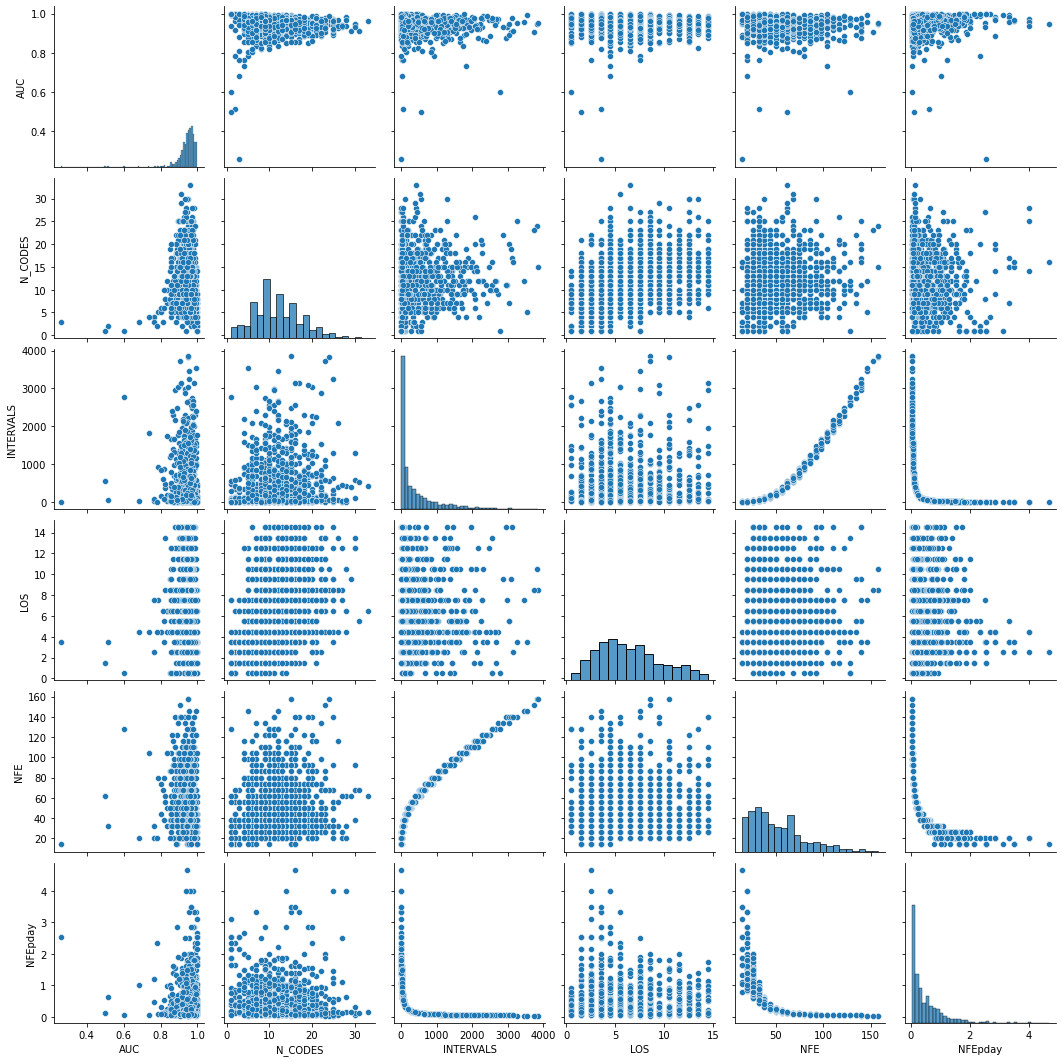

In [35]:
import seaborn as sns
sns.pairplot(icenode_stat)

In [16]:
# retain_auc_df = retain.admissions_auc_scores(retain_params, test_ids)

In [17]:
# gru_auc_df = gru.admissions_auc_scores(gru_params, test_ids)

In [18]:
# gram_auc_df = gram.admissions_auc_scores(gram_params, test_ids)

In [29]:
# gram_auc_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'HADM_IDX', 'AUC', 'N_CODES'], dtype='object')

In [21]:
icenode_auc_df.columns = ['SUBJECT_ID', 'HADM_ID', 'HADM_IDX', 'ICENODE_AUC', 'N_CODES', 'DAYS_AHEAD', 'INTERVAL', 'ICENODE_NFE']

# retain_auc_df.columns = ['SUBJECT_ID', 'HADM_ID', 'HADM_IDX', 'RETAIN_AUC', 'N_CODES']

# gru_auc_df.columns = ['SUBJECT_ID', 'HADM_ID', 'HADM_IDX', 'GRU_AUC', 'N_CODES']

# gram_auc_df.columns = ['SUBJECT_ID', 'HADM_ID', 'HADM_IDX', 'GRAM_AUC', 'N_CODES']


ValueError: Length mismatch: Expected axis has 6 elements, new values have 8 elements

In [ ]:
icenode_auc_df.HADM_ID.nunique()

In [33]:
icenode_auc_df

,SUBJECT_ID,HADM_ID,HADM_IDX,ICENODE_AUC,N_CODES,DAYS_AHEAD,INTERVAL,ICENODE_NFE
0,24198,135189,1,0.976323,9.0,1,1,8.0
1,24198,135189,2,0.976787,9.0,2,1,8.0
2,24198,135189,3,0.977097,9.0,3,1,8.0
3,24198,135189,4,0.976787,9.0,4,1,8.0
4,24198,135189,5,0.976942,9.0,5,1,8.0
...,...,...,...,...,...,...,...,...
9346,11234,150220,2,0.964360,8.0,1267,1266,98.0
9347,11234,150220,3,0.996697,8.0,1268,1,8.0
9348,11234,150220,4,0.998261,8.0,1269,1,8.0
9349,11234,150220,5,0.998435,8.0,1270,1,8.0


In [35]:
icenode_auc_df2 = icenode_auc_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])

In [37]:
icenode_auc_df2.ICENODE_AUC.mean()

0.9572364170139803

In [38]:
icenode_auc_df2

,SUBJECT_ID,HADM_ID,HADM_IDX,ICENODE_AUC,N_CODES,DAYS_AHEAD,INTERVAL,ICENODE_NFE
0,24198,135189,1,0.976323,9.0,1,1,8.0
13,24198,157166,14,0.971526,9.0,217,204,32.0
20,24198,116391,21,0.978373,7.0,336,113,26.0
25,97441,138440,1,0.977877,21.0,1,1,8.0
32,97441,194679,8,0.943302,16.0,39,32,20.0
...,...,...,...,...,...,...,...,...
9326,59496,158272,10,0.964569,12.0,20,11,14.0
9333,1949,122008,1,0.976765,11.0,1,1,8.0
9337,1949,196537,5,0.863499,13.0,10,6,14.0
9345,11234,133876,1,0.997925,4.0,1,1,8.0
